NLP Coursework Individual Part

Name: **Jack Cannings**

URN: **6497204**

Username: **JC01425**

# Intro

In this project I'm going to take a look at various data preperation methods and machine learning models for classifying the genre of a song based on the lyrics. The dataset which is used in the project has been sourced using a web scraper and the [Genius](https://docs.genius.com/) API

I'm going to use the Google Colab Hosted Service - This is so I do not need to worry about getting all the libraries working on my local machine and I can take advantage of Colabs GPU Runtime.

Using the Numpy library to set seed for the notebook so results are reproducible

In [ ]:
from numpy.random import seed
seed(1234)

As I'm using Google Colab - I'm going to save all the files related to this project in my Google drive so it isn't necessary to upload them each time and instead the drive can just be mounted.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import some of the required libraries

In [ ]:
import pandas as pd
import gensim
from gensim import corpora
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess

Load the CSV file into a Pandas Dataframe

In [ ]:
#Define the names for the columns in the data frame
colNames = ["Genre", "Song", "Artist", "Lyrics"]

#Load in the data from google drive
data = pd.read_csv('/content/drive/MyDrive/NLP/Coursework/attempt5.csv', delimiter='~', dtype=None, names=colNames)

#Load in the data from a local storage location
#data = pd.read_csv('NLP/CW/attempt4.csv', delimiter='~', dtype=None, names=colNames)

Convert each of the columns into String format and as a list so they can be formatted

In [ ]:
data["Genre"] = data.Genre.values.astype(str).tolist()
data["Song"] = data.Song.values.astype(str).tolist()
data["Artist"] = data.Artist.values.astype(str).tolist()
data["Lyrics"] = data.Lyrics.values.astype(str).tolist()

Take a look at the Unique Genres in the Dataset

In [ ]:
genres = list(set(data["Genre"]))
print(genres)

['soul', 'musicals', 'reggae', 'emo', 'grime', 'blues', 'folk', 'metal', 'christian', 'indie']


Let's take a look at one of the songs, to see what formatting needs to be done in the first instance

In [ ]:
print(data["Lyrics"][0])

And all I am is a man\nI want the world in my hands\nI hate the beach but I stand\nIn California with my toes in the sand\nUse the sleeves of my sweater\nLet's have an adventure\nHead in the clouds but my gravity's centered\nTouch my neck and I'll touch yours\nYou in those little high waisted shorts, oh\n\nShe knows what I think about\nAnd what I think about\nOne love, two mouths\nOne love, one house\nNo shirt, no blouse\nJust us, you find out\nNothing that I wouldn’t wanna tell you about, no\n\n'Cause it's too cold for you here\nAnd now, so let me hold\nBoth your hands in the holes of my sweater\n\nAnd if I may just take your breath away\nI don't mind if there's not much to say\nSometimes the silence guides a mind\nTo move to a place so far away\nThe goosebumps start to raise\nThe minute that my left hand meets your waist\nAnd then I watch your face\nPut my finger on your tongue\n'Cause you love the taste, yeah\nThese hearts adore\nEveryone the other beats hardest for\nInside this pla

In [ ]:
#Replace the double backslash new lines with single
data["Lyrics"] = [song.replace("\\n", "\n") for song in data["Lyrics"]]

#Replace the double new lines with a single new line
data["Lyrics"] = [song.replace("\n\n", "\n") for song in data["Lyrics"]]

Format is now much cleaner

In [ ]:
print(data["Lyrics"][0])

And all I am is a man
I want the world in my hands
I hate the beach but I stand
In California with my toes in the sand
Use the sleeves of my sweater
Let's have an adventure
Head in the clouds but my gravity's centered
Touch my neck and I'll touch yours
You in those little high waisted shorts, oh
She knows what I think about
And what I think about
One love, two mouths
One love, one house
No shirt, no blouse
Just us, you find out
Nothing that I wouldn’t wanna tell you about, no
'Cause it's too cold for you here
And now, so let me hold
Both your hands in the holes of my sweater
And if I may just take your breath away
I don't mind if there's not much to say
Sometimes the silence guides a mind
To move to a place so far away
The goosebumps start to raise
The minute that my left hand meets your waist
And then I watch your face
Put my finger on your tongue
'Cause you love the taste, yeah
These hearts adore
Everyone the other beats hardest for
Inside this place is warm
Outside it starts to pour

View the class distribution for each of the genres

<BarContainer object of 10 artists>

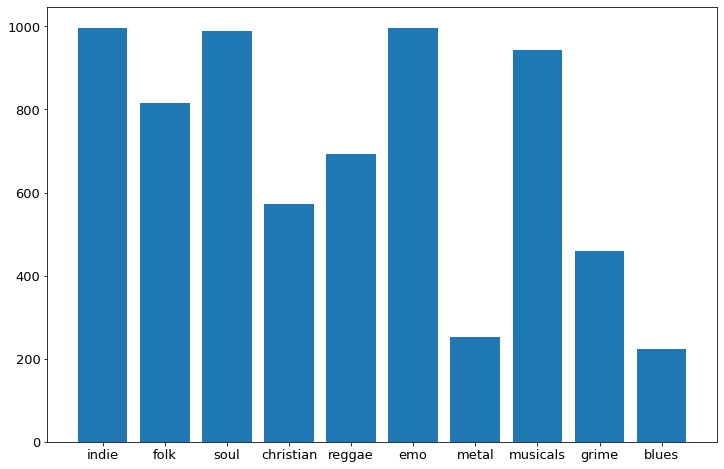

In [ ]:
#Create an empty dictionary
genre_dic_sum = {}

#Loop through each Genre and acquire the counts of each Genre in the dataset
for i in data["Genre"].unique():
   genre_dic_sum[str(i)] = len(data[data["Genre"] == i])

plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(12,8))
plt.bar(genre_dic_sum.keys(), genre_dic_sum.values())

From the chat it's clear to see that a couple of the genres are very under-represented, this is going to cause issues with training the models, which won't generalise well on these Genres, so a couple of them will be removed.

I also want to reduce this to a 5 class problem - so I am going to remove genres which I think are going to be harder to classify as the lyrics are very generic - such as indie.

In [ ]:
#Define the genres to drop
genres_to_drop = ["blues", "metal", "christian", "emo", "indie"]
# genres_to_keep = ["indie", "musicals", "metal", "christian", "grime"]

#Loop through all data, if genre in above list, drop the row.
for i in range(0, len(data)):
  if data["Genre"][i] in genres_to_drop:
    data = data.drop(index=i)


Now that we've lost a lot of data - the index must be reset. If this isn't done, any loops through the range of the dataset (range(0, len(dataset) will cause an error, as the indexes which contained the genres above have been removed. The command below resets the indexes.

In [ ]:
data = data.reset_index(drop = True)

In [ ]:
#Update the genres variable which will be used later
genres = list(set(data["Genre"]))
print(genres)

['soul', 'musicals', 'reggae', 'grime', 'folk']


We can now take another look at the genres distribution

<BarContainer object of 5 artists>

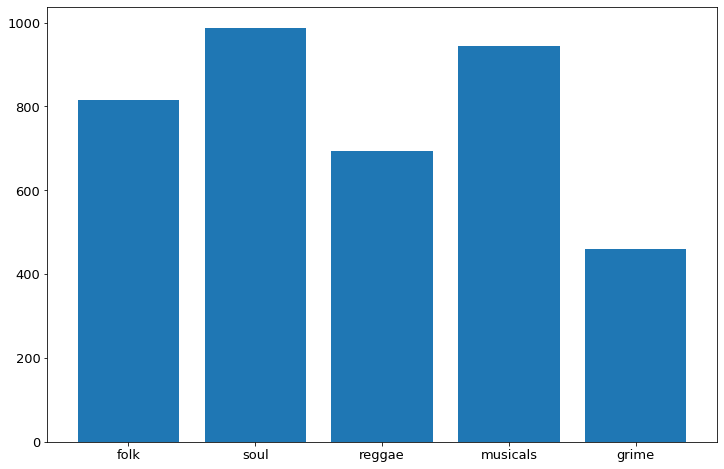

In [ ]:
#Create an empty dictionary
genre_dic_sum = {}

#Loop through each Genre and acquire the counts of each Genre in the dataset
for i in data["Genre"].unique():
   genre_dic_sum[str(i)] = len(data[data["Genre"] == i])
plt.rcParams.update({'font.size': 13})

plt.figure(figsize=(12,8))
plt.bar(genre_dic_sum.keys(), genre_dic_sum.values())

There are still a couple of classes which are less represented - but these classes, Grime and Reggae, are very distinct in the language used, so I do not believe this is going to cause issues with the classifier.

Now we need to do some more data cleaning - this is going to involve removing duplicates, grammar, and converting everything to lower case.

First, removing duplicates

In [ ]:
#An array to store the indexes of songs which are duplicates
duplicated_indexes = []

#Loop through the whole dataset and append the indexes of duplicates songs to above array.
for i in range(0, len(data)):
  if data.duplicated(subset=(["Song"] + ["Artist"]))[i] == True:
    duplicated_indexes += [i]


Before removing the indexes stored in the array, I wanted to validate that this method wasn't going to delete both instances of a song, so I wrote a loop to view the song names assigned to these indexes.

In [ ]:
songs = []
for i in duplicated_indexes:
  songs.append(data["Song"][i])

From observing the contents of this varaible, I can see that only a single instance of each song is going to be removed, unless that song appeared >2 times in the dataset.

In [ ]:
sorted(songs)

['Addicted',
 'All Is Found (Kacey Musgraves Version)',
 'All I’ve Ever Known',
 'All My Friends',
 'An Evening I Will Not Forget (Acoustic)',
 "Arsonist's Lullabye",
 'Between the Bars',
 'Chant',
 'Chant II',
 'Cherry Wine (Live)',
 'Come On Eileen',
 'Count on Me',
 'Epic III',
 'For Island Fires and Family',
 "Foreigner's God",
 'From Eden',
 'Glory',
 "I Know Where I've Been",
 "If I Go, I'm Goin",
 'In a Week',
 'In the Woods Somewhere',
 'It Will Come Back',
 'Jackie and Wilson',
 'Just Friends',
 'Lady Marmalade',
 'Like Real People Do',
 'Livin’ It Up on Top',
 "Master Blaster (Jammin')",
 "Moment's Silence (Common Tongue)",
 'Moments Passed',
 'NFWMB',
 'No Woman',
 'Privacy',
 'Redemption Song',
 'Road to Hell',
 'Run',
 'Save Yourself',
 'Sedated',
 'Shrike',
 'Someone New',
 'The Song of Purple Summer',
 'Thinking Out Loud',
 'To Be Alone',
 'Wait for Me',
 'Way Down Hadestown']

Time to drop the indexes which contain the duplicated songs and then reset the index once more.

In [ ]:
for i in duplicated_indexes:
  data = data.drop(index=i)

data = data.reset_index(drop = True)

Once again take a look at the class distribution.

<BarContainer object of 5 artists>

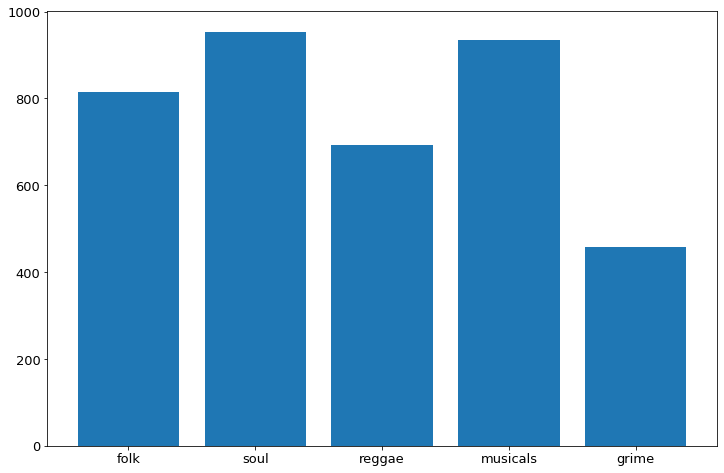

In [ ]:
#Create an empty dictionary
genre_dic_sum = {}

#Loop through each Genre and acquire the counts of each Genre in the dataset
for i in data["Genre"].unique():
   genre_dic_sum[str(i)] = len(data[data["Genre"] == i])
plt.rcParams.update({'font.size': 13})

plt.figure(figsize=(12,8))
plt.bar(genre_dic_sum.keys(), genre_dic_sum.values())

Some more data cleaning needs to happen now - We'll use the regular expression library to remove punctuation, and then convert all song words to lowercase.

In [ ]:
# Load the regular expression library
import re

# Remove punctuation
data['lyrics_processed'] = data['Lyrics'].map(lambda x: re.sub('[,()\.!?\']', '', x))

# Convert the titles to lowercase
data['lyrics_processed'] = data['lyrics_processed'].map(lambda x: x.lower())


Take a look at the difference in total characters

In [ ]:
print("Char length of Song 1 with punctuation: {} - Song 1 without punctuation: {}"
  .format(len(data["Lyrics"][1]), len(data["lyrics_processed"][1])))

Char length of Song 1 with punctuation: 1901 - Song 1 without punctuation: 1809


In [ ]:
print("Total characters in dataset with punctuation: {}".format(sum(len(i) for i in data["Lyrics"])))
print("Total characters in dataset without punctuation: {}".format(sum(len(i) for i in data["lyrics_processed"])))
print("Difference: -{}".format((sum(len(i) for i in data["Lyrics"])) - (sum(len(i) for i in data["lyrics_processed"]))))

Total characters in dataset with punctuation: 7786001
Total characters in dataset without punctuation: 7515276
Difference: -270725


Create a function which we can use to convert the lyrics sentences into individual word tokens

In [ ]:
def sent_to_words(songs):
    for song in songs:
        yield(gensim.utils.simple_preprocess(str(song), deacc=True))  # deacc=True removes any remaining punctuations


song_data = data["lyrics_processed"].tolist()
song_data_words = list(sent_to_words(song_data))

Let's compare a songs before and after tokenisation.

In [ ]:
print(f'Before tokenisation: \n\n{song_data[0][:44]} \n \nAfter tokenisation: \n\n{song_data_words[0][:10]}')

Before tokenisation: 

now ive heard there was a secret chord
that  
 
After tokenisation: 

['now', 'ive', 'heard', 'there', 'was', 'secret', 'chord', 'that', 'david', 'played']


Let's flatten the song_data_words variable so we can see how many words there are in the dataset.

This number is still very large - but there is more processing to come.

In [ ]:
import itertools
flat_words = list(itertools.chain(*song_data_words))
len(flat_words)

1459221

Add this new list with lyrics tokenised to the dataframe, along with an extra column which contains the length of the song in tokens, this could be useful later for calculating average song lengths.

In [ ]:
data['lyrics_words'] = 0
data['song_length'] = 0

for i in range(0, len(song_data_words)):
    data['lyrics_words'][i] = song_data_words[i]
    data['song_length'][i] = len(song_data_words[i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Let's have a look at the average song length - this may be used for the sequence length later for the models.

This has been calculated before the removal of stopwords, so we will recalculate this afterwards and compare the difference. 

In [ ]:
average_length = round(sum(data.song_length) / len(data))
print(f'Average length of a song in the dataset: {average_length}')

Average length of a song in the dataset: 379


Removing Stopwords

To remove stopwords, I will use the NLTK Corpus Eng Stopwords library - we may remove additional stopwords later on after observing the most popular words which remain after this process.

In [ ]:
#Import the required library
import nltk
from nltk.corpus import stopwords

#Download the stopwords
nltk.download('stopwords')

#Assign the english stopwords to a variable
eng_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Create a new col in the data to hold the lyrics info with stopwords removed
data['lyrics_words_stopwords'] = data.lyrics_words

#Loop over every song in the dataset. For each song, loop through the words.
#If the word does not exist in the eng_stopwords list, then that word can remain, otherwise it is dropped.

for song in range(0, len(data['lyrics_words_stopwords'])):
    data['lyrics_words_stopwords'][song] = [word for word in data['lyrics_words_stopwords'][song] if not word in eng_stopwords]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Let's compare some of the numbers now that stopwords have been removed:

In [ ]:
flat_words_stopwords = list(itertools.chain(*data['lyrics_words_stopwords']))
dataset_vocabulary = list(sorted(set(flat_words)))
dataset_vocabulary_stopwords = list(sorted(set(flat_words_stopwords)))

print(f'Number of words BEFORE stopwords have been removed {len(flat_words)}')
print(f'Number of words AFTER stopwords have been removed {len(flat_words_stopwords)} \n')
print(f'Vocabulary length BEFORE stopwords have been removed {len(dataset_vocabulary)}')
print(f'Vocabulary length AFTER stopwords have been removed {len(dataset_vocabulary_stopwords)}')

Number of words BEFORE stopwords have been removed 1459221
Number of words AFTER stopwords have been removed 886272 

Vocabulary length BEFORE stopwords have been removed 56180
Vocabulary length AFTER stopwords have been removed 56038


The size of the dataset has almost been cut in half in terms of tokens, this is going to positively impact the time it takes to train the models and will hopefully make each genre more distinctive.

And now recalculate the average length of each song with stopwords removed

In [ ]:
data['song_length_stopwords'] = 0

for i in range(0, len(data)):
    data['song_length_stopwords'][i] = len(data["lyrics_words_stopwords"][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
average_length_stopwords = round(sum(data.song_length_stopwords) / len(data))
print(f'Average length of a song in the dataset with stopwords removed: {average_length_stopwords}')
print(f'Average length of a song in the dataset: {average_length}')
print(f'Difference: -{average_length - average_length_stopwords}')

Average length of a song in the dataset with stopwords removed: 230
Average length of a song in the dataset: 379
Difference: -149


Let's view the most common words remaining in the dataset after these stopwords have been removed

In [ ]:
#Import some of the required libs
import numpy as np
from collections import Counter

#Use counter library to total up each word in the lyrics stopwords data column.
post_stopwords_counts = Counter(flat_words_stopwords)

top20 = dict(zip(dict(post_stopwords_counts.most_common(20)).keys(), np.zeros(20)))

for song in data.lyrics_words_stopwords:
  for word in top20.keys():
    if word in song:
      top20[word] += 1
for key in top20.keys():
  top20[key] = str("{0:.0%}".format(round(top20[key]/len(data), 2)))

top20

{'baby': '22%',
 'come': '36%',
 'dont': '53%',
 'get': '43%',
 'go': '44%',
 'got': '42%',
 'im': '57%',
 'know': '59%',
 'like': '57%',
 'love': '42%',
 'man': '31%',
 'never': '39%',
 'oh': '42%',
 'one': '44%',
 'say': '40%',
 'see': '45%',
 'time': '41%',
 'wanna': '26%',
 'yeah': '36%',
 'youre': '37%'}

It's clear that a few words are still present in the majority of songs, such as 'im' which is present in 60% of the songs in the dataset. For now though, I won't be removing any more tokens and will move onto additional data experimentation. This is something that could be returned to in the future.

The next step is to create a Lemmatised dataset and a stemmed dataset. Both of these datasets will then be experimented with,

First up is Lemmatise:

In [ ]:
#Create a new col to hold the lemmatised lyrics
data['Lyrics_Lem'] = data['lyrics_words_stopwords']

In [ ]:
#Following code has been taken from NLP Lab - Dr Bogdan V

#Import library
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    # now we need to convert from nltk to wordnet POS notations (for compatibility reasons)
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) # return and default to noun if not found

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
#Use Lemmatiser function on data - this can take a while to run.

#Download Wordnet
nltk.download('wordnet')

#Apply lemmatisation
for i in range(0, len(data['Lyrics_Lem'])):
  data['Lyrics_Lem'][i] = [lemmatizer.lemmatize(x, pos=get_wordnet_pos(x)) for x in data['Lyrics_Lem'][i]]



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Now let's try some stemming - this is an easier process than lemmatising

In [ ]:
#We can use NLTK for stemming, again.

#Import the stemmer
from nltk.stem.porter import PorterStemmer

#Create a new column for the stemmed tokens
data['Lyrics_Stem'] = data['lyrics_words_stopwords']

#Create stem function
stemmer = PorterStemmer()

#Loop over all songs in data and apply stemmer to each word:
for song_index in range(0, len(data)):
  data['Lyrics_Stem'][song_index] = [stemmer.stem(word) for word in data['Lyrics_Stem'][song_index]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Let's compare Normal Tokens, Lemma Tokens and Stemmed Tokens

In [ ]:
print(f'Normal tokens: \n\n {data["lyrics_words"][10][:15]} \n\n')
print(f'Lemma tokens: \n\n {data["Lyrics_Lem"][10][:15]} \n\n')
print(f'Stemmed tokens: \n\n {data["Lyrics_Stem"][10][:15]} \n\n')

Normal tokens: 

 ['can', 'see', 'you', 'standing', 'honey', 'with', 'his', 'arms', 'around', 'your', 'body', 'laughin', 'but', 'the', 'jokes'] 


Lemma tokens: 

 ['see', 'stand', 'honey', 'arm', 'around', 'body', 'laughin', 'joke', 'funny', 'take', 'five', 'whole', 'minute', 'pack', 'u'] 


Stemmed tokens: 

 ['see', 'stand', 'honey', 'arm', 'around', 'bodi', 'laughin', 'joke', 'funni', 'took', 'five', 'whole', 'minut', 'pack', 'us'] 




The final bit of pre-processing that we need to do is one-hot-encoding for the labels

In [ ]:
#Import Keras one hot encoding lib:
from keras.utils.np_utils import to_categorical


#new col for the genre one-hot-encodings
data['genre_ohe'] = data['Genre']


genreDic = {}
for i in range(0,len(genres)):
    genreDic[str(genres[i])] = i

for i in range(0, len(data['genre_ohe'])):
    if data['genre_ohe'][i] in genreDic.keys():
        data['genre_ohe'][i] = genreDic[data['genre_ohe'][i]]


data['genre_ohe'] = list(to_categorical(list(data['genre_ohe'])))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [ ]:
genreDic

{'folk': 4, 'grime': 3, 'musicals': 1, 'reggae': 2, 'soul': 0}

Have a look at the one hot encoded labels

In [ ]:
data['genre_ohe']

0       [0.0, 0.0, 0.0, 0.0, 1.0]
1       [1.0, 0.0, 0.0, 0.0, 0.0]
2       [0.0, 0.0, 1.0, 0.0, 0.0]
3       [0.0, 0.0, 0.0, 0.0, 1.0]
4       [0.0, 0.0, 1.0, 0.0, 0.0]
                  ...            
3849    [0.0, 1.0, 0.0, 0.0, 0.0]
3850    [0.0, 1.0, 0.0, 0.0, 0.0]
3851    [0.0, 1.0, 0.0, 0.0, 0.0]
3852    [0.0, 1.0, 0.0, 0.0, 0.0]
3853    [0.0, 1.0, 0.0, 0.0, 0.0]
Name: genre_ohe, Length: 3854, dtype: object

At this point, looking at the dataframe below - we have a few different forms of the same dataset which can be experimented with. 

lyrics_processed - The original lyrics with the only changes being the tidying of the formatting and punctuations removed.

lyrics_words - this is the same data as lyrics_processed, but the words have been split into individual tokens.

lyrics_words_stopwords - this is the data after the stopwords have been removed.

Lyrics_lem - the stopwords column data with lemmatisation applied.

Lyrics_stem - the stopwords column data with stemming applied.

In [ ]:
data

,Genre,Song,Artist,Lyrics,lyrics_processed,lyrics_words,song_length,lyrics_words_stopwords,song_length_stopwords,Lyrics_Lem,Lyrics_Stem,genre_ohe
0,folk,Hallelujah,Leonard Cohen,Now I've heard there was a secret chord\nThat ...,now ive heard there was a secret chord\nthat d...,"[now, ive, heard, there, was, secret, chord, t...",324,"[ive, heard, secret, chord, david, played, ple...",185,"[ive, heard, secret, chord, david, played, ple...","[ive, heard, secret, chord, david, play, pleas...","[0.0, 0.0, 0.0, 0.0, 1.0]"
1,soul,Too Good at Goodbyes,Sam Smith,You must think that I'm stupid\nYou must think...,you must think that im stupid\nyou must think ...,"[you, must, think, that, im, stupid, you, must...",386,"[must, think, im, stupid, must, think, im, foo...",213,"[must, think, im, stupid, must, think, im, foo...","[must, think, im, stupid, must, think, im, foo...","[1.0, 0.0, 0.0, 0.0, 0.0]"
2,reggae,Work,Rihanna,"Work, work, work, work, work, work\nHe said me...",work work work work work work\nhe said me haff...,"[work, work, work, work, work, work, he, said,...",547,"[work, work, work, work, work, work, said, haf...",361,"[work, work, work, work, work, work, say, haff...","[work, work, work, work, work, work, said, haf...","[0.0, 0.0, 1.0, 0.0, 0.0]"
3,folk,Revenge,XXXTENTACION,"I think I, I think I finally\nFound a way to f...",i think i i think i finally\nfound a way to fo...,"[think, think, finally, found, way, to, forgiv...",227,"[think, think, finally, found, way, forgive, m...",140,"[think, think, finally, found, way, forgive, m...","[think, think, final, found, way, forgiv, mist...","[0.0, 0.0, 0.0, 0.0, 1.0]"
4,reggae,Side To Side,Ariana Grande,I've been here all night (Ariana)\nI've been h...,ive been here all night ariana\nive been here ...,"[ive, been, here, all, night, ariana, ive, bee...",500,"[ive, night, ariana, ive, day, nicki, minaj, b...",296,"[ive, night, ariana, ive, day, nicki, minaj, b...","[ive, night, ariana, ive, day, nicki, minaj, b...","[0.0, 0.0, 1.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
3849,musicals,Wait for Me (”If you wanna walk out of hell......,"André De Shields, Reeve Carney, Eva Noblezada,...","What is it?\nWell, the good news is, he said t...",what is it\nwell the good news is he said that...,"[what, is, it, well, the, good, news, is, he, ...",175,"[well, good, news, said, go, theres, bad, news...",72,"[well, good, news, say, go, there, bad, news, ...","[well, good, news, said, go, there, bad, news,...","[0.0, 1.0, 0.0, 0.0, 0.0]"
3850,musicals,Who I'd Be,Brian D'Arcy James,"I guess I'd be a hero, with sword and armor cl...",i guess id be a hero with sword and armor clas...,"[guess, id, be, hero, with, sword, and, armor,...",360,"[guess, id, hero, sword, armor, clashing, look...",222,"[guess, id, hero, sword, armor, clash, look, s...","[guess, id, hero, sword, armor, clash, look, s...","[0.0, 1.0, 0.0, 0.0, 0.0]"
3851,musicals,Killer Quest,Original Cast of The Lightning Thief Musical,(Spoken)\nMy mom's gone.\n(Spoken)\nFrom this ...,spoken\nmy moms gone\nspoken\nfrom this world ...,"[spoken, my, moms, gone, spoken, from, this, w...",393,"[spoken, moms, gone, spoken, world, shes, anyw...",242,"[spoken, mom, go, spoken, world, shes, anywher...","[spoken, mom, gone, spoken, world, she, anywhe...","[0.0, 1.0, 0.0, 0.0, 0.0]"
3852,musicals,Sudden Changes/ Feed Me (Git it),Alan Menken,Sudden changes surround me\nLady Luck came and...,sudden changes surround me\nlady luck came and...,"[sudden, changes, surround, me, lady, luck, ca...",635,"[sudden, changes, surround, lady, luck, came, ...",383,"[sudden, change, surround, lady, luck, come, f...","[sudden, chang, surround, ladi, luck, came, fo...","[0.0, 1.0, 0.0, 0.0, 0.0]"


Now that the major data pre-processing has been completed - it's time to fit model tokenisers on the data and split it up into training and testing sets so we can train and evaluate models.

For the tokenisation, I will be using the keras-preprocessing tokeniser.

A function which takes a dataset as input and returns the X and Y training sets, as well as the testing sets.

In [ ]:
#Create the testing / training split function, which we can call later on, for each type of data, which will return all the required varaibles for training.

def createSplits(lyrics, labels, sequence_length, pad='post', data_split=0.8):
  import numpy as np
  from keras.preprocessing.text import Tokenizer
  from keras.preprocessing import sequence
  from sklearn.utils import shuffle

  
  tokenizer = Tokenizer()

  tokenizer.fit_on_texts(lyrics)

  sequences = tokenizer.texts_to_sequences(lyrics)

  training_x = np.asarray(sequence.pad_sequences(sequences, maxlen=sequence_length, padding=pad))
  training_y = np.asarray(labels)

  max_token = max(itertools.chain(*training_x))
  
  training_x, training_y = shuffle(training_x, training_y)

  split = round(len(training_x)*data_split)

  x_train = training_x[:split]
  y_train = training_y[:split]

  x_test = training_x[split:]
  y_test = training_y[split:]

  return [[x_train, y_train], [x_test, y_test], max_token]

It's now time to define some models which we will train and compare.

For this project, I'm going to be using the follow models:

- Bi-Directional LSTM
- Standard LSTM
- Convolutional Neural Networl
- A hybrid which contains Convolutional Layers as well as LSTM.

Define the Bi-Directional LSTM

In [ ]:
def biLSTM(max_token, x, y, optimiser, num_epochs, batch, sequence_length):
  import numpy as np
  from tensorflow import keras
  from tensorflow.keras import layers

  training_x = np.asarray(x)
  training_y = np.asarray(y)

  print(f'\n\n TRAINING BIDIRECTIONAL-LSTM MODEL \n\n')


  inputs = keras.Input(shape=(sequence_length,))
  x = layers.Embedding(max_token + 1, 50)(inputs)
  x = layers.Bidirectional(layers.LSTM(50, dropout=0.2))(x)
  outputs = layers.Dense(5, activation="softmax")(x)
  model_bi = keras.Model(inputs, outputs)


  model_bi.summary()


  model_bi.compile(loss='categorical_crossentropy',
                optimizer=optimiser,
                metrics=['accuracy'])

  # Train Model
  model_bi.fit(training_x, training_y, batch_size=batch, epochs=num_epochs)

  return model_bi

Define the LSTM

In [ ]:
def LSTM_MODEL(max_token, x, y, optimiser, num_epochs, batch, sequence_length):
  from keras.models import Sequential
  from keras.layers import Embedding, LSTM, Dense

  training_x = np.asarray(x)
  training_y = np.asarray(y)

  print(f'\n\n TRAINING LSTM MODEL \n\n')

  lstm_model = Sequential()
  lstm_model.add(Embedding(max_token + 1, 10, input_length=sequence_length))
  lstm_model.add(LSTM(50))
  lstm_model.add(Dense(5, activation='softmax'))

  lstm_model.compile(loss='categorical_crossentropy',
                optimizer=optimiser,
                metrics=['accuracy'])

  lstm_model.fit(training_x, training_y,
            batch_size=batch,
            epochs=num_epochs)
  
  return lstm_model

Define the CNN

In [ ]:
def CNN(max_token, x, y, optimiser, num_epochs, batch, sequence_length, act):

  from keras.models import Model
  from keras.models import Sequential
  from keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Flatten, Activation, Embedding

  training_x = np.asarray(x)
  training_y = np.asarray(y)

  print(f'\n\n TRAINING CNN MODEL \n\n')

  cnn_model = Sequential()
  cnn_model.add(Embedding(max_token + 1, 200, input_length=sequence_length))
  cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
  cnn_model.add(Dropout(0.5))
  cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  cnn_model.add(Dropout(0.5))
  cnn_model.add(Flatten())
  cnn_model.add(Dense(50, activation='relu'))
  cnn_model.add(Dropout(0.5))
  cnn_model.add(Dense(5, activation=act))

  cnn_model.compile(loss='categorical_crossentropy', 
                optimizer=optimiser, metrics=['accuracy'])
  
  cnn_model.fit(training_x, training_y, batch_size = batch, epochs = num_epochs)

  return cnn_model

Define the hybrid, CNN/LSTM merged model.

In [ ]:
def mergedLSTMCNN(max_token, x, y, optimiser, num_epochs, batch, sequence_length):
  from keras.models import Model
  from keras.models import Sequential
  from keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Flatten, Activation, Embedding, LSTM

  training_x = np.asarray(x)
  training_y = np.asarray(y)

  print(f'\n\n TRAINING MIXEL MODEL \n\n')

  model = Sequential()
  model.add(Embedding(max_token+1, 32, input_length=sequence_length))
  model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(Dropout(0.2))
  model.add(MaxPooling1D(pool_size=2))
  model.add(LSTM(100))
  model.add(Dropout(0.2))
  model.add(Dense(5, activation='sigmoid'))
  model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['accuracy'])
  print(model.summary())
  model.fit(training_x, training_y, epochs=num_epochs, batch_size=batch)

  return model

For each of the data / model combinations, I want to be able to evaluat the results.

Below is a evaluation function which takes the model, test data and class names as arguments, predicts the classes of the test data, and then calculates a confusion matrix and a classification_report which contains metrics such as Precision and Recall.

In [ ]:
def evaluateModel(model, test_x, test_y, class_names):
  import sklearn
  from sklearn.metrics import confusion_matrix, classification_report
  import seaborn as sn
  import pandas as pd
  import matplotlib.pyplot as plt

  test_x = np.asarray(test_x)
  test_y = np.asarray(test_y)

  predicted_classes = np.argmax(model.predict(test_x), axis=1)
  true_classes = [np.where(r==1)[0][0] for r in test_y]

  correctly_classified = 0
  for i in range (0, len(predicted_classes)):
      if predicted_classes[i] == true_classes[i]:
          correctly_classified += 1

  accuracy = correctly_classified / len(true_classes)

  print(f'Model accuracy on test data: {accuracy} \n\n')

  prediction_report = classification_report(predicted_classes, true_classes, target_names=class_names)

  print(f'Classification Report: \n {prediction_report} \n\n')

  conf = sklearn.metrics.confusion_matrix(predicted_classes, true_classes)

  df_cm = pd.DataFrame(conf, index = [i for i in class_names], columns = [i for i in class_names])
  sn.set(font_scale=1.4) # for label size
  ax = sn.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g')

  print(ax)

  return prediction_report, conf

Below are methods implemented to automate the whole process of training the models on each of the different data columns in the frame.

Automating this and storing the results in numpy arrays means that laborious code for training and evaluating every combination doesn't need to be done manually.

In [ ]:
#I need to prind the genre dictionary so I can look at the indexes for each genre
#This is important for the evaluation function - I need to pass in a list with the genres in the right order
#so that the confusion matrix is accurate.
genreDic

{'folk': 4, 'grime': 3, 'musicals': 1, 'reggae': 2, 'soul': 0}

Below are dictionaries which contain each of the data columns and each of the models.

In [ ]:
genres = ["soul", "musicals", "reggae", "grime", "folk"]
data_tests = {"processed": data.lyrics_processed, "words": data.lyrics_words, "stopwords": data.lyrics_words_stopwords, "Stemmed": data.Lyrics_Stem, "Lemmatised": data.Lyrics_Lem}

#All models commented out to allow for further CNN only testing.

#model_tests = {"BiDirectionalLSTM": biLSTM, "normalLSTM": LSTM_MODEL, "CNN": CNN, "Merged LSTM + CNN": mergedLSTMCNN}

model_tests = {"CNN": CNN}

The loop below iterates over each of the data columns, and trained and evaluates each of the models on each one, and then stores the results in an additional dictionary so the results can be saves and observed.

This can take well over an hour to run



 TRAINING CNN MODEL 


Epoch 1/10
49/49 [==============================] - 8s 156ms/step - loss: 1.5406 - accuracy: 0.2768
Epoch 2/10
49/49 [==============================] - 8s 154ms/step - loss: 1.4219 - accuracy: 0.3406
Epoch 3/10
49/49 [==============================] - 8s 154ms/step - loss: 1.2201 - accuracy: 0.4419
Epoch 4/10
49/49 [==============================] - 8s 157ms/step - loss: 0.9086 - accuracy: 0.6195
Epoch 5/10
49/49 [==============================] - 8s 156ms/step - loss: 0.6338 - accuracy: 0.7484
Epoch 6/10
49/49 [==============================] - 8s 156ms/step - loss: 0.4590 - accuracy: 0.8250
Epoch 7/10
49/49 [==============================] - 8s 153ms/step - loss: 0.3406 - accuracy: 0.8805
Epoch 8/10
49/49 [==============================] - 8s 157ms/step - loss: 0.2556 - accuracy: 0.9061
Epoch 9/10
49/49 [==============================] - 8s 156ms/step - loss: 0.1765 - accuracy: 0.9271
Epoch 10/10
49/49 [==============================] - 8s 156ms/step - loss: 

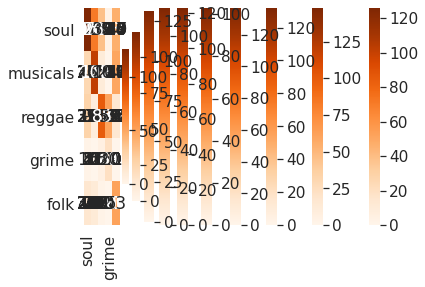

In [ ]:
models = {}
evaluations = {}
confusion_matri = {}

for i in data_tests:
  for mod in model_tests:
    for act in ['softmax', 'sigmoid']:
      train, test, max_voc = createSplits(data_tests[i].tolist(), data.genre_ohe.tolist(), 500)
      model = model_tests[mod](max_voc, train[0], train[1], 'adam', 10, 64, 500, act)
      eval, conf = evaluateModel(model, test[0], test[1], genres)
      models[str(i) + "-" + str(mod)] = model
      evaluations[str(i) + "-" + str(mod)+ "-" + str(act)] = eval
      confusion_matri[str(i) + "-" + str(mod)+ "-" + str(act)] = conf


As I don't want to have to repeat the training process each time I load up this notebook, I save all the results.

These first two cells print out each of the classification reports and confusion matrixes to a txt document which is saved into google drive.

These text documents can be viewed here:

**[Classification Reports](https://drive.google.com/file/d/1Flxw4wao4e-qIO3mMTcaQ0fWcOTPub6y/view?usp=sharing)**

**[Confusion Matrixes](https://drive.google.com/file/d/1-1Pj6zZQPRS0PSDQ5BuLEqDNelQ_DH0n/view?usp=sharing)**

The output results above a from additional testing of the CNN model with different activation functions and parameters - more information about this below.

In [ ]:
import sys

original_stdout = sys.stdout # Save a reference to the original standard output

with open('/content/drive/MyDrive/NLP/EvalResults_CNN_MODEL_ACTIVATION_TYPES.txt', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    for i in evaluations:
      print(i)
      print("\n")
      print(evaluations[i])
      print("\n")
      print("\n")
    sys.stdout = original_stdout # Reset the standard output to its original value

In [ ]:
import sys

original_stdout = sys.stdout # Save a reference to the original standard output

with open('/content/drive/MyDrive/NLP/ConfMatri_CNN_MODEL_ACTIVATION_TYPES.txt', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    for i in confusion_matri:
      print(i)
      print("\n")
      print(confusion_matri[i])
      print("\n")
      print("\n")
    sys.stdout = original_stdout # Reset the standard output to its original value

This cell converts the dictionaries which contain the evaluations into a numpy array, which can be loaded back into the notebook at a later date. This enables data to be played with, without having to run the models again.

In [ ]:
evals = list(evaluations.items())
evals = np.asarray(evals)

confs = list(confusion_matri.items())
confs = np.asarray(confs)


np.save("/content/drive/MyDrive/NLP/evaluations_CNN_MODEL_ACTIVATION_TYPES.npy",evals, allow_pickle=True)
np.save("/content/drive/MyDrive/NLP/confusion_matri_CNN_MODEL_ACTIVATION_TYPES.npy",confs, allow_pickle=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Below I have reloaded in the results from training all models and data so they can be viewed within the notepad.

In [ ]:
all_confs = np.load('/content/drive/MyDrive/NLP/confusion_matri.npy', allow_pickle=True)
all_reports = np.load('/content/drive/MyDrive/NLP/evaluations.npy', allow_pickle=True)

All Classification Reports:

In [ ]:
for i in all_reports:
  print(f' \n ------------------------------------------------------- \n \n {i[0]} \n\n {i[1]} \n')

 
 ------------------------------------------------------- 
 
 processed-BiDirectionalLSTM 

               precision    recall  f1-score   support

        folk       0.53      0.49      0.51       159
    musicals       0.51      0.64      0.57       144
        soul       0.53      0.50      0.52       207
      reggae       0.61      0.57      0.59       154
       grime       0.69      0.67      0.68       107

    accuracy                           0.56       771
   macro avg       0.58      0.58      0.57       771
weighted avg       0.57      0.56      0.56       771
 

 
 ------------------------------------------------------- 
 
 processed-normalLSTM 

               precision    recall  f1-score   support

        folk       0.00      0.00      0.00         0
    musicals       0.03      0.32      0.06        19
        soul       0.94      0.30      0.45       660
      reggae       0.09      0.25      0.13        53
       grime       0.32      0.69      0.44        39

  

All Confusion Matrix:

In [ ]:
for i in all_confs:
  print(f' \n ---------------------------\n \n {i[0]} \n\n {i[1]} \n')

 
 ---------------------------
 
 processed-BiDirectionalLSTM 

 [[ 78  33  33  10   5]
 [ 23  92  18   8   3]
 [ 30  32 104  30  11]
 [ 11  16  26  88  13]
 [  4   8  15   8  72]] 

 
 ---------------------------
 
 processed-normalLSTM 

 [[  0   0   0   0   0]
 [  0   6   2   2   9]
 [151 167 196 121  25]
 [  0   9   8  13  23]
 [  1   1   2   8  27]] 

 
 ---------------------------
 
 processed-CNN 

 [[ 70  28  23  23   1]
 [ 34 133  27   5   1]
 [ 25  17 105  30   5]
 [ 17   8  28  80   5]
 [  0   1   8   8  89]] 

 
 ---------------------------
 
 processed-Merged LSTM + CNN 

 [[ 73  64  30  13   0]
 [ 42  51  46  17   4]
 [ 27  59 101  73  15]
 [  2  10  19  36  42]
 [  0   0   1   5  41]] 

 
 ---------------------------
 
 words-BiDirectionalLSTM 

 [[ 90  50  52  18   5]
 [ 32 107  18   9   6]
 [ 29  37  86  26   7]
 [ 10   5  31  69   6]
 [  1   3   4   2  68]] 

 
 ---------------------------
 
 words-normalLSTM 

 [[136 128 143  91  16]
 [  2  17  12  11   1]
 [  1   8 

From the results acquired - it seemed like the CNN model and the Bi-Directional LSTM model had the most potential.

The method of training these models was in no way perfect - there are many parameters and hyper-parameters that can be tuned and changed. This method used the same batch size and epochs for each of the models - and it's clear that some models such as LSTM may benefit from more epochs.

Besides this - the purpose of this first method to evaluate all the models was to observe which was the most promising.

Additional testing of the CNN model was done following these tests.

The batch size and epochs were adjusted, and two different activation functions were tested - softmax and sigmoid.

The text files can be viewed below, as well as at these links:

**[CNN Classification Reports](https://drive.google.com/file/d/1CmwUG467ZAQ8uoBotM2pfUqIq8EQQ5vP/view?usp=sharing)**

**[CNN Confusion Matrixes](https://drive.google.com/file/d/1-4rqtWAP6_6Vw2Adgkg3K8XJhU2vqg8p/view?usp=sharing)**

To view these results, the numpy arrays need to be loaded back into the notepad:

In [ ]:
#Reimport some libraries in the event that the notepad is loaded and all cells before this point are not run.
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline 


Mounted at /content/drive


Load in the Numpy arrays from their locations in Google Drive

In [ ]:
cnn_confusion_matri = np.load('/content/drive/MyDrive/NLP/confusion_matri_CNN_MODEL_ACTIVATION_TYPES.npy', allow_pickle=True)
cnn_classification_reports = np.load('/content/drive/MyDrive/NLP/evaluations_CNN_MODEL_ACTIVATION_TYPES.npy', allow_pickle=True)

Let's have a look at the classification reports, see which combinations are the most promising.

In [ ]:
for i in cnn_classification_reports:
  print(f' \n ------------------------------------------------------- \n \n {i[0]} \n\n {i[1]} \n')

 
 ------------------------------------------------------- 
 
 processed-CNN-softmax 

               precision    recall  f1-score   support

        soul       0.70      0.61      0.65       206
    musicals       0.66      0.66      0.66       192
      reggae       0.56      0.75      0.64       110
       grime       0.80      0.91      0.85        78
        folk       0.62      0.56      0.59       185

    accuracy                           0.66       771
   macro avg       0.67      0.70      0.68       771
weighted avg       0.66      0.66      0.66       771
 

 
 ------------------------------------------------------- 
 
 processed-CNN-sigmoid 

               precision    recall  f1-score   support

        soul       0.51      0.59      0.55       153
    musicals       0.76      0.63      0.69       234
      reggae       0.58      0.52      0.55       150
       grime       0.51      0.92      0.66        51
        folk       0.56      0.52      0.54       183

    acc

From these results it seems like the following two dataset / models combinations are the best:

- Softmax Activation with the processed data - **66% Accuracy**
- Softmax Activation with the Tokenised-only data - **66% Accuracy**

There are a few other combinations which are only slightly worse, such as Softmax with the stemmed data


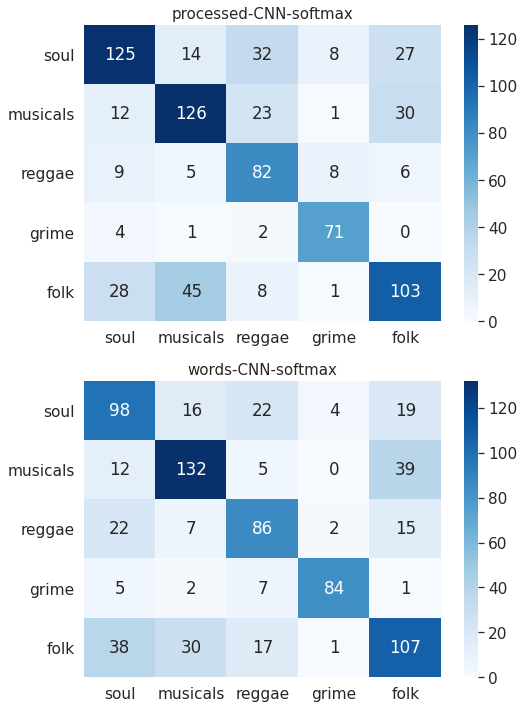

In [ ]:
#Required for plotting confusion matrix axis labels
genres = ["soul", "musicals", "reggae", "grime", "folk"]

#Just the confusion matrix that we want to see
matrixes_to_view = [cnn_confusion_matri[0], cnn_confusion_matri[2]]

#Create the subplot
fig, axn = plt.subplots(2, 1,figsize=(8,12))

#Show the confusion matrixes
for i, ax in enumerate(axn.flat):
  if i < len(cnn_classification_reports):
    df_cm = pd.DataFrame(matrixes_to_view[i][1], index = [i for i in genres], columns = [i for i in genres])
    sn.heatmap(df_cm, cmap='Blues', annot=True, fmt='g', ax=ax)
    ax.set_title(matrixes_to_view[i][0],fontsize=15)

Looking at the two confusion matrix above, Grime is by far the most consistent class, having the best recall and precision scores. I don't think this is that surprising as I'd expect Grime music to have the most distinctive lyrics.

Folk and Soul seem to struggle, with quite a few of the songs from those categories being classifies as each others. 

From the results we've seen, the model does ok at classifying the genres selected. Although 66% isn't the greatest accuracy, this is a 5 class problem and the data is far from perfect. 

Going forward - I would be interested to see the results of these models with a larger, more balanced dataset. These models could also probably be more accurate with additional tuning, but it's simply trial and error.
